In [30]:
import sklearn
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # or any model
from sklearn.preprocessing import MinMaxScaler

### Load and Preprocess .mat Images

In [31]:
import h5py
import os
import numpy as np
import cv2  # For resizing

# Folder containing the 3000 .mat files
data_dir = r"G:\1512427\New folder\brainTumorDataPublic_1-3064"  # Adjust path as needed

X = []
y = []

for filename in os.listdir(data_dir):
    if filename.endswith(".mat"):
        file_path = os.path.join(data_dir, filename)

        with h5py.File(file_path, 'r') as f:
            # Extract and transpose image (from MATLAB format)
            img = np.array(f['cjdata']['image']).T
            label = int(np.array(f['cjdata']['label'])[0][0])

            # Resize to 64x64 and flatten
            img_resized = cv2.resize(img, (64, 64))
            img_flat = img_resized.flatten()

            X.append(img_flat)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Loaded {len(X)} images with shape: {X[0].shape}")


Loaded 3064 images with shape: (4096,)


### Scale and Split the Data

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize pixel values to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Ensure labels start from 0
y_encoded = y - 1  # Shifts labels from [1, 2, 3] to [0, 1, 2]

# Stratified Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Train set shape: (2451, 4096)
Test set shape: (613, 4096)


### Show Class Distribution

Class Distribution: {0: 708, 1: 1426, 2: 930}


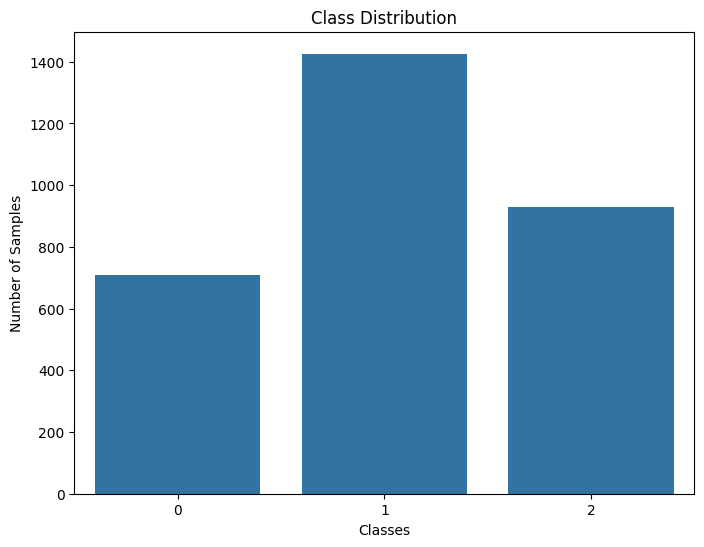

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)
unique_classes -= 1  # Shifts labels from [1, 2, 3] to [0, 1, 2]
class_distribution = dict(zip(unique_classes, class_counts))

print("Class Distribution:", class_distribution)

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

### Show Random Samples from each Class

In [34]:
# Cell to display a few upscaled images per class
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Function to display a few random images for each class
def plot_class_images(X, y, unique_classes, num_images=3):
    plt.figure(figsize=(15, 10))
    for i, class_label in enumerate(unique_classes):
        # Find all indices where the class is `class_label`
        class_indices = np.where(y == class_label)[0]
        random_indices = np.random.choice(class_indices, num_images, replace=False)
        
        for j, idx in enumerate(random_indices):
            # Reshape to 64x64 then resize to 128x128 for display
            img = X[idx].reshape(64, 64)
            img_resized = resize(img, (128, 128), anti_aliasing=True)
            
            plt.subplot(len(unique_classes), num_images, i * num_images + j + 1)
            plt.imshow(img_resized, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f'Class {class_label}')
    
    plt.tight_layout()
    plt.show()

# Example usage
# plot_class_images(X, y, unique_classes)


### Train and Test the models


In [35]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

### Curve Learning training 

In [36]:
from sklearn.model_selection import learning_curve

def plot_learning_curve_sklearn(estimator, X, y, title="Learning Curve", cv=3):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Plot Train vs Test Accuracy

#### SVC Train vs Test

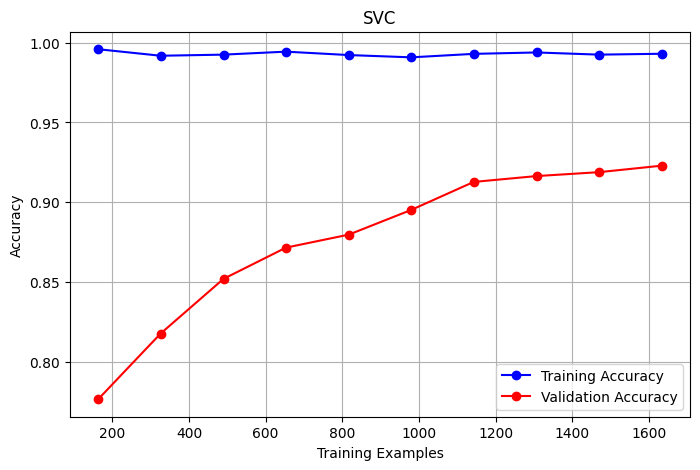

array([[0.        , 0.        , 0.        , ..., 0.02686203, 0.02059497,
        0.02581522],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01709402, 0.01601831,
        0.02038043],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01343101, 0.01258581,
        0.01358696],
       [0.        , 0.        , 0.        , ..., 0.004884  , 0.00457666,
        0.00271739]])

In [42]:
plot_learning_curve_sklearn(svm_model, X_train, y_train, title="SVC")
X_train

#### Random Forest Train vs Test

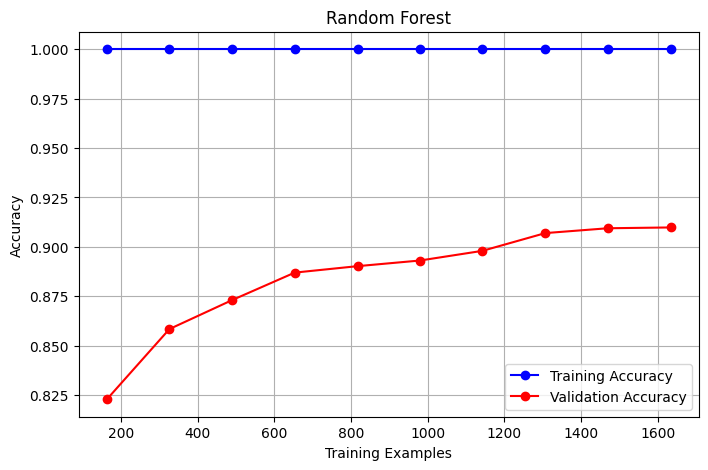

array([[0.        , 0.        , 0.        , ..., 0.02686203, 0.02059497,
        0.02581522],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01709402, 0.01601831,
        0.02038043],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01343101, 0.01258581,
        0.01358696],
       [0.        , 0.        , 0.        , ..., 0.004884  , 0.00457666,
        0.00271739]])

In [41]:
plot_learning_curve_sklearn(rf_model, X_train, y_train, title="Random Forest")
X_train

### Confusion Matrices

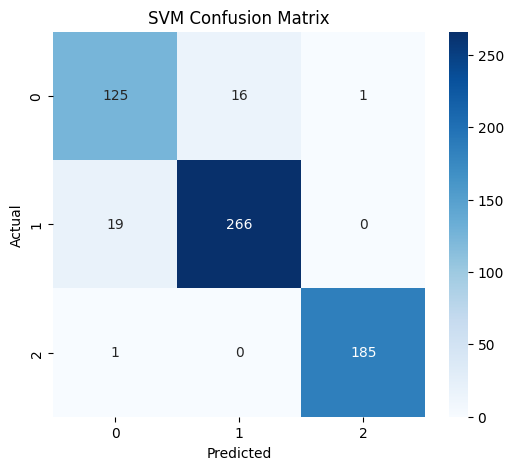

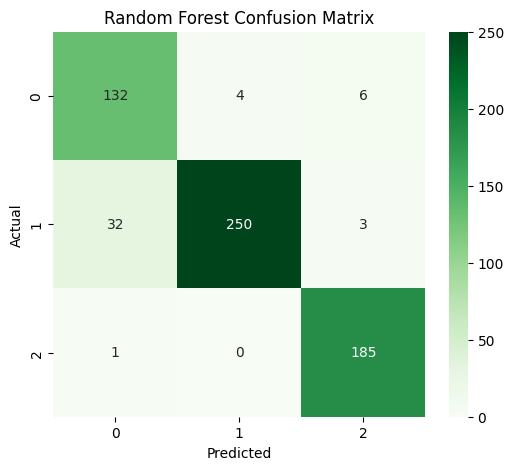

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# RF
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Classification Reports

In [40]:
from sklearn.metrics import classification_report

print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       142
           1       0.94      0.93      0.94       285
           2       0.99      0.99      0.99       186

    accuracy                           0.94       613
   macro avg       0.93      0.94      0.93       613
weighted avg       0.94      0.94      0.94       613


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       142
           1       0.98      0.88      0.93       285
           2       0.95      0.99      0.97       186

    accuracy                           0.92       613
   macro avg       0.91      0.93      0.92       613
weighted avg       0.93      0.92      0.93       613



### save the models

In [44]:
from joblib import dump, load


dump(rf_model, "random_forest.joblib")
dump(svm_model, "SVM_Classifier.joblib")

['SVM_Classifier.joblib']